In [1]:
import sys
sys.path.append('../')
sys.path.append('../../../')
import libs.data as data
import libs.utils as utils
import libs.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import libs.preprocessing as pp
import libs.semantics.vsm as vsm
import exp_libs.features as f
%matplotlib inline
import spacy
reload(vsm)

<module 'libs.semantics.vsm' from '../../../libs/semantics/vsm.py'>

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

In [3]:
df = data.load_dataframe('../../../datasets/final/en/asag_v2_en_filter_wa.csv')
df.head(2)

# Man muss die angepassten Zahlen angeben.
stats.get_all_stats(utils.convert_to_pass_fail(df['MyScore'].values), utils.convert_to_pass_fail(np.round(df['Score'].values)))

{'apcf': [0.8855254001391788,
  0.8938740486148825,
  0.8855254001391788,
  0.8842337641370964],
 'k': 0.7676262461680471,
 'mae': -0.07689631176061239,
 'r': 0.7771522980237868}

In [4]:
nlp_en = spacy.load('en')

In [5]:
import gensim.downloader as api
model_en = api.load('fasttext-wiki-news-subwords-300')

In [10]:
# Preprocessing Functions
# Keeps all stopwords, remove DET, PUNCT, SPACE,
preprocess_basic = f.create_preprocess_basic(nlp_en)
preprocess_not = f.create_preprocess_not(nlp_en)

def preprocess_basic_stops(x):
    tokens = preprocess_basic(x)
    return [t for t in tokens if not t in pp.EN_STOPS]

def preprocess_not_stops(x):
    tokens = preprocess_not(x)
    return [t for t in tokens if not t in pp.EN_STOPS]


word2word_fn = f.create_word_to_word_similarity_function(model_en)

In [8]:
# Entailment Similarity MA
entailment_sim_fn_ng3 = vsm.create_compute_entailment_similarity(word2word_fn, ngram_size=3)
entailment_ng3_ma1 = f.create_feature(df, preprocess_basic_stops, entailment_sim_fn_ng3, ma_column='MA')
np.corrcoef([entailment_ng3_ma1, df['Score']])

/home/che/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[500]: done
[1000]: done
[1500]: done
[2000]: done
[2500]: done


array([[1.        , 0.73694475],
       [0.73694475, 1.        ]])

In [9]:
# Entailment Similarity MA2
entailment_ng3_ma2 = f.create_feature(df, preprocess_basic_stops, entailment_sim_fn_ng3, ma_column='MA2')
np.corrcoef([entailment_ng3_ma2, df['Score']])

/home/che/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[500]: done
[1000]: done
[1500]: done
[2000]: done
[2500]: done


array([[1.        , 0.73956583],
       [0.73956583, 1.        ]])

In [10]:
reload(f)
# Entailment Similarity MA3
entailment_ng3_ma3 = f.create_feature(df, preprocess_basic_stops, entailment_sim_fn_ng3, ma_column='MA3')
np.corrcoef([entailment_ng3_ma3, df['Score']])

/home/che/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[500]: done
[1000]: done
[1500]: done
[2000]: done
[2500]: done


array([[1.        , 0.73614287],
       [0.73614287, 1.        ]])

In [12]:
## Max Model Answer
def get_max_values(n1, n2, n3):
    max_sim = []
    for idx in range(0, len(n1)):
        mx_value = np.max([n1[idx], n2[idx], n3[idx]])
        max_sim.append(mx_value)
    return np.array(max_sim)

entailment_sim_ma123 = get_max_values(entailment_ng3_ma1, entailment_ng3_ma2, entailment_ng3_ma3)
np.corrcoef([entailment_sim_ma123, df['Score']])

In [13]:
# Cosine Coefficient
cos_coeff_ma1 = f.create_feature(df, preprocess_basic_stops, f.cosine_coefficient, ma_column='MA')
cos_coeff_ma2 = f.create_feature(df, preprocess_basic_stops, f.cosine_coefficient, ma_column='MA2')
cos_coeff_ma3 = f.create_feature(df, preprocess_basic_stops, f.cosine_coefficient, ma_column='MA3')
cos_coeff_ma123 = get_max_values(cos_coeff_ma1, cos_coeff_ma2, cos_coeff_ma3)
np.corrcoef([cos_coeff_ma123, df['Score']])

[500]: done
[1000]: done
[1500]: done
[2000]: done
[2500]: done
[500]: done
[1000]: done
[1500]: done
[2000]: done
[2500]: done
[500]: done
[1000]: done
[1500]: done
[2000]: done
[2500]: done


array([[1.        , 0.78330814],
       [0.78330814, 1.        ]])

In [18]:
# Cosine Coefficient Not
cos_coeff_not_ma1 = f.create_feature(df, preprocess_not_stops, f.cosine_coefficient, ma_column='MA')
cos_coeff_not_ma2 = f.create_feature(df, preprocess_not_stops, f.cosine_coefficient, ma_column='MA2')
cos_coeff_not_ma3 = f.create_feature(df, preprocess_not_stops, f.cosine_coefficient, ma_column='MA3')
cos_coeff_not_ma123 = get_max_values(cos_coeff_not_ma1, cos_coeff_not_ma2, cos_coeff_not_ma3)
np.corrcoef([cos_coeff_not_ma123, df['Score']])

[1000]: done
[2000]: done
[1000]: done
[2000]: done
[1000]: done
[2000]: done


array([[1.        , 0.76992173],
       [0.76992173, 1.        ]])

In [29]:
# Length Difference Between Model Answer and Student Response
length_diff_ma1 = f.create_feature(df, preprocess_basic_stops, f.length_diff, ma_column='MA')
length_diff_ma2 = f.create_feature(df, preprocess_basic_stops, f.length_diff, ma_column='MA2')
length_diff_ma3 = f.create_feature(df, preprocess_basic_stops, f.length_diff, ma_column='MA3')

[1000]: done
[2000]: done
[1000]: done
[2000]: done
[1000]: done
[2000]: done


In [17]:
norm_max = np.max(length_diff)
norm_min = np.min(length_diff)
length_diff_norm = (length_diff - norm_min) / (norm_max - norm_min)
np.corrcoef([length_diff_norm, df['Score']])

array([[ 1.        , -0.28977985],
       [-0.28977985,  1.        ]])

In [33]:
## Count Vectors: N=1 for Ngrams
count_vec_ng1 = f.create_count_vectorizer_fn(preprocess_basic, ngram_range=(1,1), stopwords=pp.EN_STOPS)
cv_ng1_ma1 = f.create_feature_raw(df, count_vec_ng1, ma_column='MA')
cv_ng1_ma2 = f.create_feature_raw(df, count_vec_ng1, ma_column='MA2')
cv_ng1_ma3 = f.create_feature_raw(df, count_vec_ng1, ma_column='MA3')
cv_ng1_ma123 = get_max_values(cv_ng1_ma1, cv_ng1_ma2, cv_ng1_ma3)
np.corrcoef([cv_ng1_ma123, df['Score']])

/home/che/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[1000]: done
[2000]: done
[1000]: done
[2000]: done
[1000]: done
[2000]: done


array([[1.        , 0.79386911],
       [0.79386911, 1.        ]])

In [19]:
## Count Vectors: N=2 for Ngrams
count_vec_ng2 = f.create_count_vectorizer_fn(preprocess_basic, ngram_range=(2,2), stopwords=pp.EN_STOPS)
cv_ng2_ma1 = f.create_feature_raw(df, count_vec_ng2, ma_column='MA')
cv_ng2_ma2 = f.create_feature_raw(df, count_vec_ng2, ma_column='MA2')
cv_ng2_ma3 = f.create_feature_raw(df, count_vec_ng2, ma_column='MA3')
cv_ng2_ma123 = get_max_values(cv_ng2_ma1, cv_ng2_ma2, cv_ng2_ma3)
np.corrcoef([cv_ng2_ma123, df['Score']])

/home/che/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[1000]: done
[2000]: done
[1000]: done
[2000]: done
[1000]: done
[2000]: done


array([[1.        , 0.50194747],
       [0.50194747, 1.        ]])

In [26]:
reload(f)
## Count Vectors: N=3 for Ngrams
count_vec_ng3 = f.create_count_vectorizer_fn(preprocess_basic, ngram_range=(3,3), stopwords=pp.EN_STOPS)
cv_ng3_ma1 = f.create_feature_raw(df, count_vec_ng3, ma_column='MA')
cv_ng3_ma2 = f.create_feature_raw(df, count_vec_ng3, ma_column='MA2')
cv_ng3_ma3 = f.create_feature_raw(df, count_vec_ng3, ma_column='MA3')
cv_ng3_ma123 = get_max_values(cv_ng3_ma1, cv_ng3_ma2, cv_ng3_ma3)
np.corrcoef([cv_ng3_ma123, df['Score']])

/home/che/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[1000]: done
[2000]: done
[1000]: done
[2000]: done


array([[1.        , 0.31870502],
       [0.31870502, 1.        ]])

In [27]:
## Token Edit Distance
token_edit_sim_ma1 = f.create_feature(df, preprocess_basic_stops, f.edit_similarity, ma_column='MA')
token_edit_sim_ma2 = f.create_feature(df, preprocess_basic_stops, f.edit_similarity, ma_column='MA2')
token_edit_sim_ma3 = f.create_feature(df, preprocess_basic_stops, f.edit_similarity, ma_column='MA3')
token_edit_sim_ma123 = get_max_values(token_edit_sim_ma1, token_edit_sim_ma2, token_edit_sim_ma3)
np.corrcoef([token_edit_sim_ma123, df['Score']])

[1000]: done
[2000]: done
[1000]: done
[2000]: done
[1000]: done
[2000]: done


array([[1.        , 0.12042655],
       [0.12042655, 1.        ]])

In [30]:
def preprocess_wms(x):
    x2 = preprocess_basic_stops(x)
    x3 = ' '.join(x2)
    return x3
    
wms_fn = f.create_wmsimilarity(model_en)
wms_values_ma1 = f.create_feature(df, preprocess_wms, wms_fn, ma_column='MA')
wms_values_ma2 = f.create_feature(df, preprocess_wms, wms_fn, ma_column='MA2')
wms_values_ma3 = f.create_feature(df, preprocess_wms, wms_fn, ma_column='MA3')
wms_values_ma123 = get_max_values(wms_values_ma1, wms_values_ma2, wms_values_ma3)
np.corrcoef([wms_values_ma123, df['Score']])

[1000]: done
[2000]: done
[1000]: done
[2000]: done
[1000]: done
[2000]: done


array([[1.        , 0.60470836],
       [0.60470836, 1.        ]])

In [36]:
all_columns = ['Entailment_N3_MA1', 'Entailment_N3_MA2','Entailment_N3_MA3',
               'Cosine_Coeff_MA1', 'Cosine_Coeff_MA2', 'Cosine_Coeff_MA3',
               'Cosine_Coeff_Not_MA1','Cosine_Coeff_Not_MA2', 'Cosine_Coeff_Not_MA3',
               'Length_Diff_MA1','Length_Diff_MA2', 'Length_Diff_MA3',
               'CV_N1_MA1', 'CV_N1_MA2', 'CV_N1_MA3',
               'CV_N2_MA1', 'CV_N2_MA2', 'CV_N2_MA3',
               'CV_N3_MA1', 'CV_N3_MA2', 'CV_N3_MA3',
               'Token_Edit_Sim_MA1', 'Token_Edit_Sim_MA2', 'Token_Edit_Sim_MA3',
               'WM_Sim_MA1', 'WM_Sim_MA2', 'WM_Sim_MA3']

all_features = np.array([entailment_ng3_ma1, entailment_ng3_ma2, entailment_ng3_ma3,
                         cos_coeff_ma1, cos_coeff_ma2, cos_coeff_ma3, 
                         cos_coeff_not_ma1, cos_coeff_not_ma2, cos_coeff_not_ma3,
                         length_diff_ma1, length_diff_ma2, length_diff_ma3,
                         cv_ng1_ma1, cv_ng1_ma2, cv_ng1_ma3,
                         cv_ng2_ma1, cv_ng2_ma2, cv_ng2_ma3,
                         cv_ng3_ma1, cv_ng3_ma2, cv_ng3_ma3,
                         token_edit_sim_ma1, token_edit_sim_ma2, token_edit_sim_ma3,
                         wms_values_ma1, wms_values_ma2, wms_values_ma3
                        ])

df_all_features = pd.DataFrame(all_features.T, columns=all_columns)
df_all_features.to_csv('../tmp/all_features.csv', sep='~', index=False)
df_all_features.head(2)

Entailment_N3_MA1  Entailment_N3_MA2  Entailment_N3_MA3  Cosine_Coeff_MA1  \
0           0.652366           0.723633           0.741721           0.18334   
1           0.140055           0.205122           0.195751           0.00000   

   Cosine_Coeff_MA2  Cosine_Coeff_MA3  Cosine_Coeff_Not_MA1  \
0          0.108465           0.09167               0.18334   
1          0.000000           0.00000               0.00000   

   Cosine_Coeff_Not_MA2  Cosine_Coeff_Not_MA3  Length_Diff_MA1     ...      \
0              0.108465               0.09167        -2.000000     ...       
1              0.000000               0.00000         0.857143     ...       

   CV_N2_MA3  CV_N3_MA1  CV_N3_MA2  CV_N3_MA3  Token_Edit_Sim_MA1  \
0        0.0        0.0        0.0        0.0               0.050   
1        0.0        0.0        0.0        0.0               0.125   

   Token_Edit_Sim_MA2  Token_Edit_Sim_MA3  WM_Sim_MA1  WM_Sim_MA2  WM_Sim_MA3  
0            0.047619            0.045455    0.891850    0.894347    0.884334  
1            0.166667            0.125000    0.737214    0.732713    0.692560  

[2 rows x 27 columns]

In [14]:
df_all = pd.read_csv('../tmp/all_features.csv', sep='~', index_col=False)
df_all.head(2)

Entailment_N3_MA1  Entailment_N3_MA2  Entailment_N3_MA3  Cosine_Coeff_MA1  \
0           0.652366           0.723633           0.741721           0.18334   
1           0.140055           0.205122           0.195751           0.00000   

   Cosine_Coeff_MA2  Cosine_Coeff_MA3  Cosine_Coeff_Not_MA1  \
0          0.108465           0.09167               0.18334   
1          0.000000           0.00000               0.00000   

   Cosine_Coeff_Not_MA2  Cosine_Coeff_Not_MA3  Length_Diff_MA1     ...      \
0              0.108465               0.09167        -2.000000     ...       
1              0.000000               0.00000         0.857143     ...       

   CV_N2_MA3  CV_N3_MA1  CV_N3_MA2  CV_N3_MA3  Token_Edit_Sim_MA1  \
0        0.0        0.0        0.0        0.0               0.050   
1        0.0        0.0        0.0        0.0               0.125   

   Token_Edit_Sim_MA2  Token_Edit_Sim_MA3  WM_Sim_MA1  WM_Sim_MA2  WM_Sim_MA3  
0            0.047619            0.045455    0.891850    0.894347    0.884334  
1            0.166667            0.125000    0.737214    0.732713    0.692560  

[2 rows x 27 columns]

In [ ]:

#x_train, x_test, y_train, y_test = train_test_split(df_features.as_matrix(), df['Class2_Score'], test_size=0.25, random_state=22, stratify=df['Class3_Score'])
#clf.fit(x_train, y_train)

#y_pred = clf.predict(x_test)

## Exp. 01.1: Multilayer Perceptron Solver

Only use 1 Model Answer

             precision    recall  f1-score   support

          0       0.83      0.73      0.78      1281
          1       0.42      0.37      0.39       644
          2       0.61      0.76      0.68       949

avg / total       0.67      0.66      0.66      2874

Pearson's R: 0.6285348670073067
Cohen's Kappa: 0.46979567938418654
MAE: -0.13743910925539318
Accuracy: 65.76%
Precision: 66.51%
Recall: 65.76%
F1-Measure: 65.67%


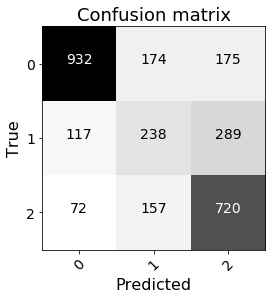

In [59]:
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(256,128,64), random_state=1)

feature_vectors_ma1 = np.array([cos_coeff_ma1, cos_coeff_not_ma1, 
                            entailment_ng3_ma1, wms_values_ma1,
                            cv_ng1_ma1, cv_ng2_ma1, cv_ng3_ma1,
                            length_diff_norm, token_edit_sim_ma1])

feature_columns_ma1 = [ 'COS_COEFF', 'COS_COEFF_NOT', 
                    'ENTAILMENT_N3', 'WM_SIM',
                    'CV_N1', 'CV_N2', 'CV_N3',
                    'LENGTH_DIFF', 'TOKEN_EDIT_SIM']

df_features_ma1 = pd.DataFrame(feature_vectors_ma1.T, columns=feature_columns_ma1)

y_true_2 = df['Class2_Score']
y_true_3 = df['Class3_Score']

pred_results_ma1 = cross_val_predict(mlp_clf, df_features_ma1.as_matrix(), y_true_3, cv=5)

results_ma1 = stats.get_all_stats(y_true_3, pred_results_ma1)
stats.print_all_stats(y_true_3, pred_results_ma1)
stats.plot_confusion_matrix(stats.cm(y_true_3, pred_results_ma1), classes=np.arange(3))
data.save('../tmp/results/mlp_cross_validate_5_class3_ma1', results_ma1)

             precision    recall  f1-score   support

          0       0.88      0.66      0.76      1341
          1       0.76      0.92      0.83      1533

avg / total       0.82      0.80      0.80      2874

Pearson's R: 0.6124611730220336
Cohen's Kappa: 0.5944427886590066
MAE: -0.11795407098121086
Accuracy: 80.13%
Precision: 81.63%
Recall: 80.13%
F1-Measure: 79.68%


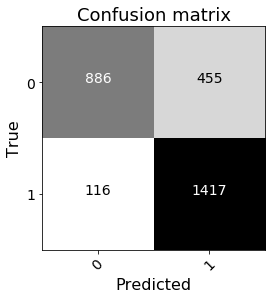

In [62]:
# Pass/Fail
pred_results_ma1_pf = cross_val_predict(mlp_clf, df_features_ma1.as_matrix(), y_true_2, cv=5)

results_ma1_pf = stats.get_all_stats(y_true_2, pred_results_ma1_pf)
stats.print_all_stats(y_true_2, pred_results_ma1_pf)
stats.plot_confusion_matrix(stats.cm(y_true_2, pred_results_ma1_pf), classes=np.arange(2))
data.save('../tmp/results/mlp_cross_validate_5_class2_ma1', results_ma1_pf)

## Exp. 01.2: Multilayer Perceptron Solver

1. Use Best of 3 Model Answers

             precision    recall  f1-score   support

          0       0.84      0.75      0.79      1281
          1       0.41      0.40      0.40       644
          2       0.66      0.78      0.72       949

avg / total       0.69      0.68      0.68      2874

Pearson's R: 0.6879950739912897
Cohen's Kappa: 0.5029772382289766
MAE: -0.10751565762004175
Accuracy: 67.81%
Precision: 68.62%
Recall: 67.81%
F1-Measure: 67.94%


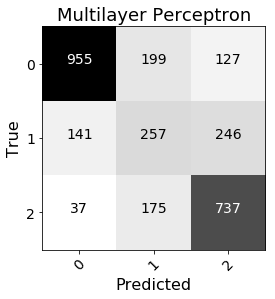

In [67]:
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(256,128,64), random_state=1)

feature_vectors = np.array([cos_coeff_ma123, cos_coeff_not_ma123, 
                            entailment_sim_ma123, wms_values_ma123,
                            cv_ng1_ma123, cv_ng2_ma123, cv_ng3_ma123,
                            length_diff_norm, token_edit_sim_ma123])

feature_columns = [ 'COS_COEFF', 'COS_COEFF_NOT', 
                    'ENTAILMENT_N3', 'WM_SIM',
                    'CV_N1', 'CV_N2', 'CV_N3',
                    'LENGTH_DIFF', 'TOKEN_EDIT_SIM']

df_features = pd.DataFrame(feature_vectors.T, columns=feature_columns)

#pred_results = cross_val_predict(mlp_clf, df_features.as_matrix(), y_true_3, cv=5)

results = stats.get_all_stats(y_true_3, pred_results)
stats.print_all_stats(y_true_3, pred_results)
stats.plot_confusion_matrix(stats.cm(y_true_3, pred_results), 
                            title='Multilayer Perceptron', 
                            classes=np.arange(3),
                            savefile='../renderings/mlp')

In [60]:
data.save('../tmp/results/mlp_cross_validate_5_class3_ma3', results)

             precision    recall  f1-score   support

          0       0.90      0.71      0.79      1341
          1       0.78      0.93      0.85      1533

avg / total       0.84      0.82      0.82      2874

Pearson's R: 0.6563831516750879
Cohen's Kappa: 0.6429618302095796
MAE: -0.09881697981906751
Accuracy: 82.46%
Precision: 83.58%
Recall: 82.46%
F1-Measure: 82.17%


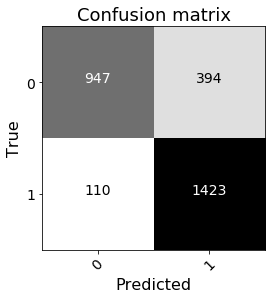

In [61]:
## Pass/Fail?

pred_results_pf = cross_val_predict(mlp_clf, df_features.as_matrix(), y_true_2, cv=5)

results_pf = stats.get_all_stats(y_true_2, pred_results_pf)
stats.print_all_stats(y_true_2, pred_results_pf)
stats.plot_confusion_matrix(stats.cm(y_true_2, pred_results_pf), classes=np.arange(2))
data.save('../tmp/results/mlp_cross_validate_5_class2_ma3', pred_results_pf)

## Exp 02: Random Forests Classification

             precision    recall  f1-score   support

          0       0.80      0.75      0.78      1281
          1       0.40      0.35      0.38       644
          2       0.65      0.76      0.70       949

avg / total       0.66      0.66      0.66      2874

Pearson's R: 0.6493165564664464
Cohen's Kappa: 0.4779777011917443
MAE: -0.07724425887265135
Accuracy: 66.49%
Precision: 66.15%
Recall: 66.49%
F1-Measure: 66.13%


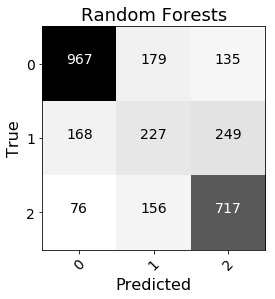

In [68]:
rf_clf = RandomForestClassifier(n_estimators=150, random_state=1)
#pred_results_e2_c3 = cross_val_predict(rf_clf, df_features.as_matrix(), y_true_3, cv=5)

results_e2_c3 = stats.get_all_stats(y_true_3, pred_results_e2_c3)
stats.print_all_stats(y_true_3, pred_results_e2_c3)
stats.plot_confusion_matrix(stats.cm(y_true_3, pred_results_e2_c3), 
                            title='Random Forests', 
                            classes=np.arange(3),
                            savefile='../renderings/random_forests')
data.save('../tmp/results/random_forests_cross_validate_5_class3', results_e2_c3)

## Exp. 03: Logistic Regression

             precision    recall  f1-score   support

          0       0.77      0.81      0.79      1281
          1       0.39      0.21      0.28       644
          2       0.65      0.81      0.72       949

avg / total       0.65      0.68      0.65      2874

Pearson's R: 0.6712724842032496
Cohen's Kappa: 0.48566666557505067
MAE: -0.05741127348643006
Accuracy: 67.68%
Precision: 64.75%
Recall: 67.68%
F1-Measure: 65.30%


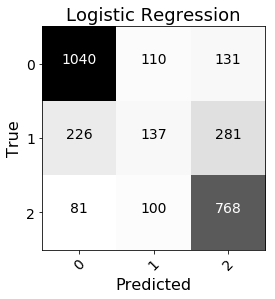

In [69]:
logreg = LogisticRegression(random_state=1, solver='lbfgs', multi_class='multinomial')

#pred_results_e3_c3 = cross_val_predict(logreg, df_features.as_matrix(), y_true_3, cv=5)

results_e3_c3 = stats.get_all_stats(y_true_3, pred_results_e3_c3)
stats.print_all_stats(y_true_3, pred_results_e3_c3)
stats.plot_confusion_matrix(stats.cm(y_true_3, pred_results_e3_c3), 
                            title='Logistic Regression', 
                            classes=np.arange(3),
                            savefile='../renderings/logistic_regression')
data.save('../tmp/results/logistic_regression_cross_validate_5_class3', results_e3_c3)

In [176]:
# How does it break down per problem?

def inspect_results(df, y_true, y_pred):
    idxs = np.unique(df['ID'].values)
    
    for idx in idxs:
        mask = df['ID'] == idx
        tmp_true = y_true[mask]
        tmp_pred = y_pred[mask]
        print('=============')
        print('ID: {}'.format(idx))
        stats.print_all_stats(tmp_true, tmp_pred)
        stats.plot_confusion_matrix(stats.cm(tmp_true, tmp_pred), classes=np.arange(3))
        print('=============')

y_pred = clf.predict(df_features.as_matrix())
#inspect_results(df3, df3['Class3_Score'], y_pred)

In [92]:
import libs.debug.tsne as tsne

pca = tsne.compute(df_features.as_matrix(), perplexity=50)

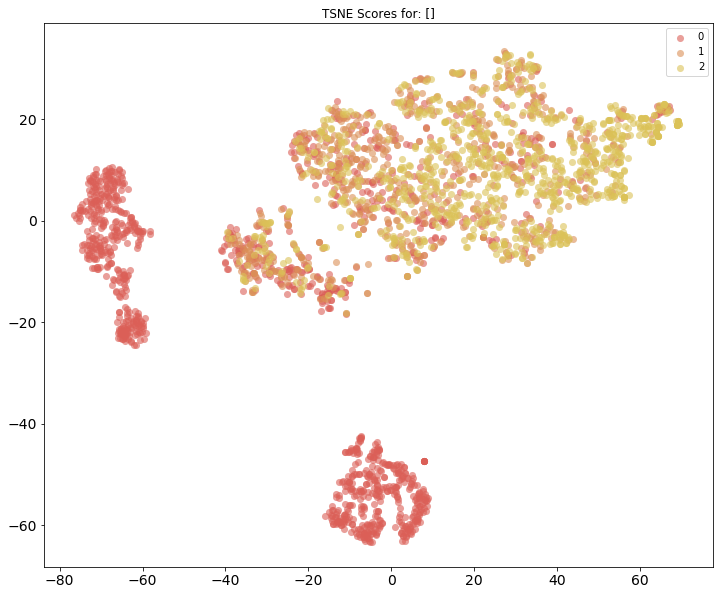

In [94]:
tsne.plot(pca, df['Class3_Score'])

In [98]:
dfc = df_features.copy()
dfc['SA'] = df['SA']
dfc['Score3'] = df['Class3_Score'] 

# short wrong answers
#idxs = tsne.get_indexes(pca, [-20, 20], [-75, -40])
#df[idxs]

#idxs = tsne.get_indexes(pca, [-80, -55], [-30, 20])
#dfc[idxs]

In [99]:
def test_student_response(clf, qid, model_answer, neg_answer, student_response, min_max=[0,1]):
    
    # feature 01
    f1 = count_vec(model_answer, student_response)
    
    # feature 02
    ma2 = preprocess_fn(model_answer)
    sa2 = preprocess_fn(student_response)
    f2 = cosine_coefficient(set(ma2), set(sa2))
    
    # feature 03 : cosine sim w/not
    ma3 = preprocess_not(model_answer)
    sa3 = preprocess_not(student_response)
    f3 = cosine_coefficient(set(ma3), set(sa3))
    
    # feature 04 : length difference
    ma = [t.lemma_ for t in nlp_en(model_answer) if not t.pos_ in ['PUNCT', 'DET'] and len(t.text.lower()) > 1]
    sa = [t.lemma_ for t in nlp_en(student_response) if not t.pos_ in ['PUNCT', 'DET'] and len(t.text.lower()) > 1]
    f4 = len(ma) - len(sa)
    f4 = (f4 - min_max[0]) / (min_max[1] - min_max[0])
    
    # feature 05 : vector similarity
    ma = pipeline_fn(row['MA'])
    sa = pipeline_fn(row['SA'])
    ma_t = nlp_en(' '.join(ma))
    sa_t = nlp_en(' '.join(sa))
    f5 = ma_t.similarity(sa_t)
    
    # feature 06
    na = preprocess_stops(neg_answer)
    sa6 = preprocess_stops(student_response)
    f6 = cosine_coefficient(set(na), set(sa2))
    
    # ID one-hot encoding feature
    cols = question_id_features.columns.tolist()
    id_one_hot = np.zeros(len(cols), dtype=np.int)
    id_one_hot[cols.index(qid)] = 1
    f7 = id_one_hot.tolist()
    
    vec = np.array([f1,f2,f3,f4,f5,f6] + f7)
    print(vec[:7])
    
    return clf.predict([vec])


idx = 100
qid = df.iloc[idx]['ID']
ma = df.iloc[idx]['MA']
prompt = df.iloc[idx]['Prompt']
na = df.iloc[idx]['NA']
print('[{}]: {}'.format(qid, prompt))
print(ma)
test_student_response(clf, qid, ma, na, "abstraction and reusability", min_max=[norm_min, norm_max])

[1.3]:  What are the main advantages associated with object-oriented programming? 
 Abstraction and reusability. 


NameError: name 'count_vec' is not defined

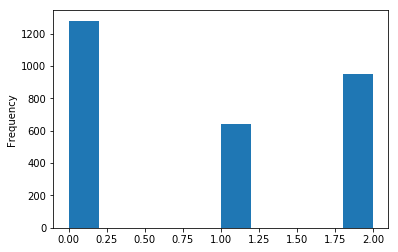

In [239]:
df3['Class3_Score'].plot(kind='hist')